# Progressive Pretrain → Classification: Results Analysis

训练完成后，从磁盘加载各 run/stage 的结果文件，汇总并绘制：
1. **Accuracy vs Pretrain Stages** — 分类准确率随 pretrain source task 数量的变化
2. **Per-class Metrics** (ALL test) — 5 classes × 3 metrics (precision, recall, f1)
3. **Per-class Metrics** (n_elements ≥ 4) — 仅含组分元素数 ≥ 4 的 test 样本

支持多台 machine 上分别训练各 run，最终将 `runXX/` 目录复制到同一 `output_dir` 下后运行本 notebook。

In [1]:
import json
from pathlib import Path

import matplotlib.pyplot as plt
import numpy as np

%matplotlib inline

## 1. 设置路径

将 `OUTPUT_DIR` 指向训练脚本产出的根目录（包含 `run01/`, `run02/`, ... 子目录）。

In [2]:
# === 修改此处指向你的训练输出目录 ===
OUTPUT_DIR = Path("../artifacts/multi_task_suite_260206_260211")

# 自动从 experiment_records.json 获取 class_names（如果存在）
# 否则手动指定
CLASS_NAMES = ["DAC", "DQC", "IAC", "IQC", "others"]

print(f"Output dir: {OUTPUT_DIR}")
print(f"Exists: {OUTPUT_DIR.exists()}")
if OUTPUT_DIR.exists():
    runs = sorted([d.name for d in OUTPUT_DIR.iterdir() if d.is_dir() and d.name.startswith("run")])
    print(f"Found {len(runs)} run(s): {runs}")

Output dir: ../artifacts/multi_task_suite_260206_260211
Exists: True
Found 4 run(s): ['run01', 'run02', 'run03', 'run04']


## 2. 加载工具函数

In [3]:
def load_clf_reports_from_disk(root_dir: Path, report_name: str = "clf_report_all.json"):
    """
    扫描 root_dir 下所有 run/stage 的 clf report JSON。
    返回 dict: {run_label: {stage_idx: report_dict}}
    目录结构: root_dir / runXX / pretrain_stageNN_xxx / finetune / material_type / <report_name>
    """
    results = {}
    for p in sorted(root_dir.glob(f"run*/pretrain_stage*/finetune/material_type/{report_name}")):
        parts = p.relative_to(root_dir).parts
        run_label = parts[0]
        stage_str = parts[1]  # e.g. 'pretrain_stage01_efermi'
        stage_idx = int(stage_str.split("_")[1].replace("stage", ""))
        with open(p) as f:
            report = json.load(f)
        results.setdefault(run_label, {})[stage_idx] = report
    return results


def load_metrics_from_disk(root_dir: Path):
    """
    扫描 root_dir 下所有 run/stage 的 metrics.json。
    返回 dict: {run_label: {stage_idx: metrics_dict}}
    """
    results = {}
    for p in sorted(root_dir.glob("run*/pretrain_stage*/finetune/material_type/metrics.json")):
        parts = p.relative_to(root_dir).parts
        run_label = parts[0]
        stage_str = parts[1]
        stage_idx = int(stage_str.split("_")[1].replace("stage", ""))
        with open(p) as f:
            metrics = json.load(f)
        results.setdefault(run_label, {})[stage_idx] = metrics
    return results


def load_experiment_records(root_dir: Path):
    """Load experiment_records.json if available."""
    path = root_dir / "experiment_records.json"
    if path.exists():
        with open(path) as f:
            return json.load(f)
    return None


print("Utility functions defined.")

Utility functions defined.


## 3. 加载数据

In [4]:
# Load metrics
metrics_by_run = load_metrics_from_disk(OUTPUT_DIR)
print(f"Found {len(metrics_by_run)} run(s) with metrics")

# Determine n_stages from data
n_stages = 0
for run_label, stages in metrics_by_run.items():
    n_stages = max(n_stages, max(stages.keys()))
    print(f"  {run_label}: stages {sorted(stages.keys())}")

print(f"\nTotal stages: {n_stages}")

# Build accuracy matrix
accuracy_matrix = []
run_labels = sorted(metrics_by_run.keys())
for run_label in run_labels:
    stages = metrics_by_run[run_label]
    accs = []
    for s in range(1, n_stages + 1):
        if s in stages:
            accs.append(stages[s].get("test_accuracy"))
        else:
            accs.append(None)
    accuracy_matrix.append(accs)

# Load experiment records for task sequence info
experiment_records = load_experiment_records(OUTPUT_DIR)
if experiment_records:
    print(f"\nExperiment records: {len(experiment_records)} run(s)")
else:
    print("\nNo experiment_records.json found (optional).")

Found 4 run(s) with metrics
  run01: stages [1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13]
  run02: stages [1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13]
  run03: stages [1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13]
  run04: stages [1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13]

Total stages: 13

No experiment_records.json found (optional).


## 4. Accuracy vs Pretrain Stages

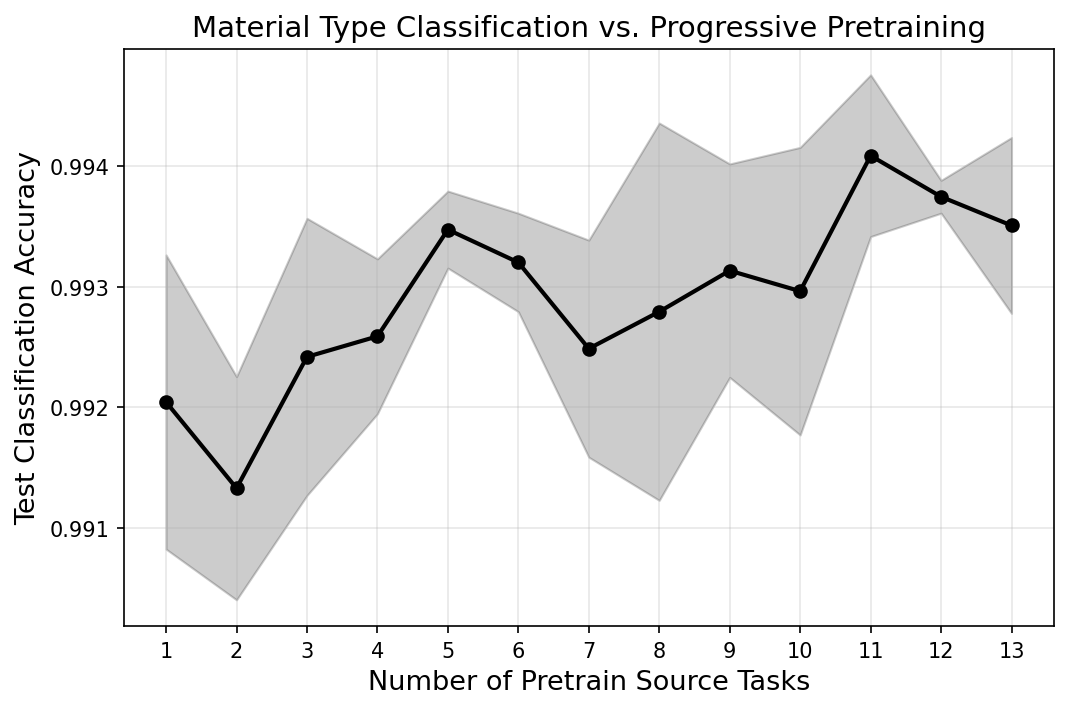


=== Accuracy Summary ===
  Stage 1: mean=0.9920 ± 0.0012
  Stage 2: mean=0.9913 ± 0.0009
  Stage 3: mean=0.9924 ± 0.0011
  Stage 4: mean=0.9926 ± 0.0006
  Stage 5: mean=0.9935 ± 0.0003
  Stage 6: mean=0.9932 ± 0.0004
  Stage 7: mean=0.9925 ± 0.0009
  Stage 8: mean=0.9928 ± 0.0016
  Stage 9: mean=0.9931 ± 0.0009
  Stage 10: mean=0.9930 ± 0.0012
  Stage 11: mean=0.9941 ± 0.0007
  Stage 12: mean=0.9937 ± 0.0001
  Stage 13: mean=0.9935 ± 0.0007


In [15]:
fig, ax = plt.subplots(figsize=(8, 5), dpi=150)

# Mean ± Std
acc_array = np.array([
    [a if a is not None else np.nan for a in row]
    for row in accuracy_matrix
])
mean_acc = np.nanmean(acc_array, axis=0)
std_acc = np.nanstd(acc_array, axis=0)
stages_x = np.arange(1, n_stages + 1)

ax.plot(stages_x, mean_acc, "o-", color="black", linewidth=2, markersize=6)
ax.fill_between(stages_x, mean_acc - std_acc, mean_acc + std_acc, alpha=0.2, color="black")

ax.set_xlabel("Number of Pretrain Source Tasks", fontsize=13)
ax.set_ylabel("Test Classification Accuracy", fontsize=13)
ax.set_title("Material Type Classification vs. Progressive Pretraining", fontsize=14)
ax.set_xticks(stages_x)
ax.grid(True, alpha=0.3)

fig.savefig(OUTPUT_DIR / "accuracy_vs_stages.png", bbox_inches="tight")
plt.show()

print("\n=== Accuracy Summary ===")
for s in range(n_stages):
    print(f"  Stage {s+1}: mean={mean_acc[s]:.4f} ± {std_acc[s]:.4f}")

## 5. Per-Run Summary

In [6]:
if experiment_records:
    print("=== Per-Run Summary ===")
    for record in experiment_records:
        run = record["run"]
        seq = record["task_sequence"]
        # Get final accuracy from finetune records
        ft_records = record.get("finetune", [])
        final_acc = ft_records[-1].get("test_accuracy") if ft_records else None
        if final_acc is not None:
            print(f"  {run}: order={seq}, final_acc={final_acc:.4f}")
        else:
            print(f"  {run}: order={seq}, no result")
else:
    print("=== Per-Run Summary (from metrics.json) ===")
    for run_label, accs in zip(run_labels, accuracy_matrix):
        final_acc = accs[-1] if accs else None
        if final_acc is not None:
            print(f"  {run_label}: final_acc={final_acc:.4f}")
        else:
            print(f"  {run_label}: no result")

=== Per-Run Summary (from metrics.json) ===
  run01: final_acc=0.9936
  run02: final_acc=0.9924
  run03: final_acc=0.9936
  run04: final_acc=0.9944


## 6. Per-class Classification Metrics vs Pretrain Stages

从磁盘加载各 run/stage 的 `clf_report_all.json` 和 `clf_report_ge4.json`，  
汇总后绘制 5 classes × 3 metrics 的 subplot（支持不同 machine 上的 run 结果合并）。

In [7]:
def plot_per_class_metrics(
    reports_by_run,
    class_names,
    n_stages,
    title_suffix="",
    save_dir=None,
):
    """
    为每个 class 绘制独立的 1×3 subplots（precision, recall, f1-score）。
    每组图: mean ± std 随 pretrain stage 数量的变化。
    reports_by_run: {run_label: {stage_idx: clf_report_dict}}
    返回和之前一样的 arr (shape [n_runs, n_stages, n_classes, n_metrics])。
    """
    metrics_of_interest = ["precision", "recall", "f1-score"]
    n_classes = len(class_names)
    n_metrics = len(metrics_of_interest)
    n_runs = len(reports_by_run)

    # shape [n_runs, n_stages, n_classes, n_metrics]
    arr = np.full((n_runs, n_stages, n_classes, n_metrics), np.nan)

    for r_idx, (run_label, stages_dict) in enumerate(sorted(reports_by_run.items())):
        for s_idx_1based, report in stages_dict.items():
            s_idx = s_idx_1based - 1  # 0-based
            if not report:
                continue
            for c_idx, cname in enumerate(class_names):
                if cname in report:
                    for m_idx, metric in enumerate(metrics_of_interest):
                        arr[r_idx, s_idx, c_idx, m_idx] = report[cname].get(metric, np.nan)

    mean_vals = np.nanmean(arr, axis=0)
    std_vals = np.nanstd(arr, axis=0)
    stages_x = np.arange(1, n_stages + 1)
    colors = plt.cm.tab10.colors

    for c_idx, cname in enumerate(class_names):
        fig, axes = plt.subplots(1, n_metrics, figsize=(4 * n_metrics, 3.5), sharey=True)

        for m_idx, metric in enumerate(metrics_of_interest):
            ax = axes[m_idx]
            mu = mean_vals[:, c_idx, m_idx]
            sd = std_vals[:, c_idx, m_idx]

            ax.plot(stages_x, mu, "o-", color=colors[c_idx], linewidth=1.5, markersize=5)
            ax.fill_between(stages_x, mu - sd, mu + sd, alpha=0.2, color=colors[c_idx])

            ax.set_ylim(-0.05, 1.05)
            ax.set_xticks(stages_x)
            ax.set_title(metric.capitalize(), fontsize=12, fontweight="bold")
            ax.set_xlabel("# pretrain source tasks")
            ax.grid(True, alpha=0.3)

        axes[0].set_ylabel("Score", fontsize=11)
        fig.suptitle(
            f"{cname} — Metrics vs Pretrain Stages{title_suffix}",
            fontsize=13, fontweight="bold",
        )
        fig.tight_layout()

        if save_dir:
            safe_suffix = title_suffix.replace(" ", "_").replace("≥", "ge").replace("(", "").replace(")", "")
            save_path = save_dir / f"per_class_{cname}{safe_suffix}.png"
            fig.savefig(save_path, dpi=150, bbox_inches="tight")
            print(f"  Saved: {save_path}")

        plt.show()

    return arr


print("plot_per_class_metrics() defined.")

plot_per_class_metrics() defined.


Loading reports from: ../artifacts/multi_task_suite_260206_260211

Found 4 run(s) with clf_report_all
  Saved: ../artifacts/multi_task_suite_260206_260211/per_class_DAC_ALL_test.png


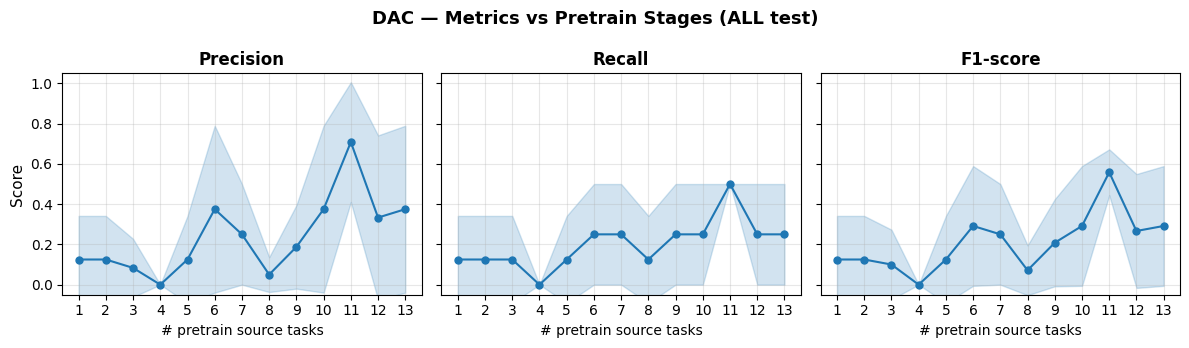

  Saved: ../artifacts/multi_task_suite_260206_260211/per_class_DQC_ALL_test.png


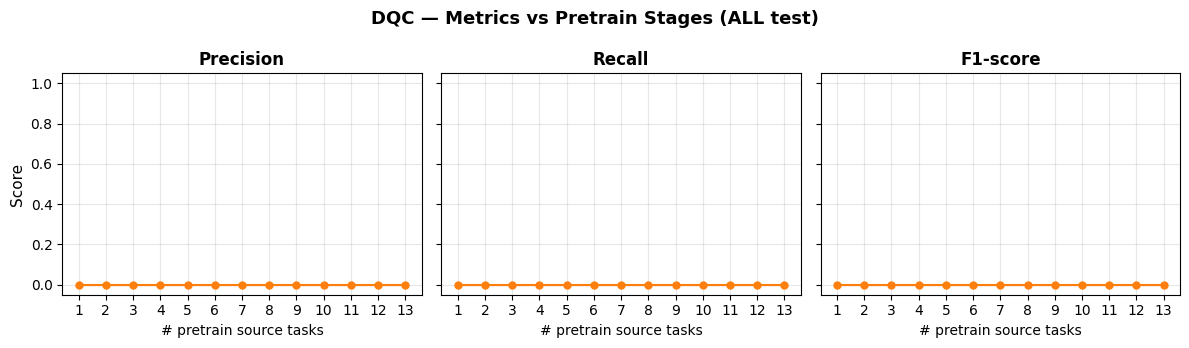

  Saved: ../artifacts/multi_task_suite_260206_260211/per_class_IAC_ALL_test.png


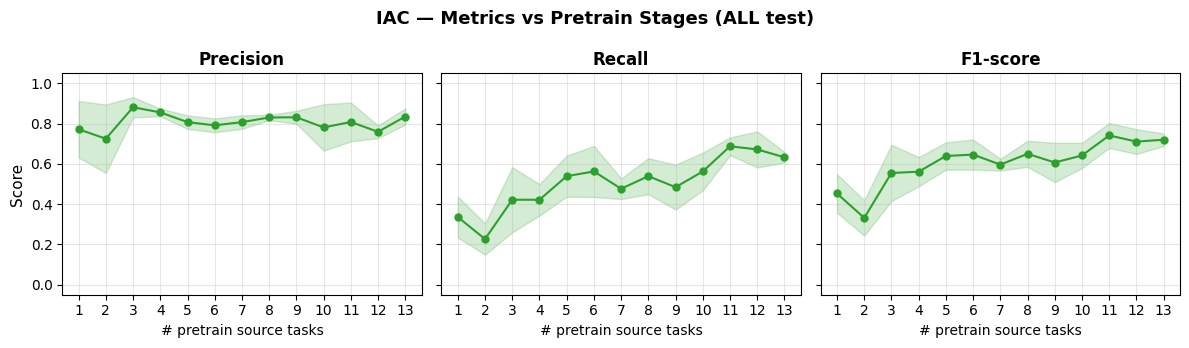

  Saved: ../artifacts/multi_task_suite_260206_260211/per_class_IQC_ALL_test.png


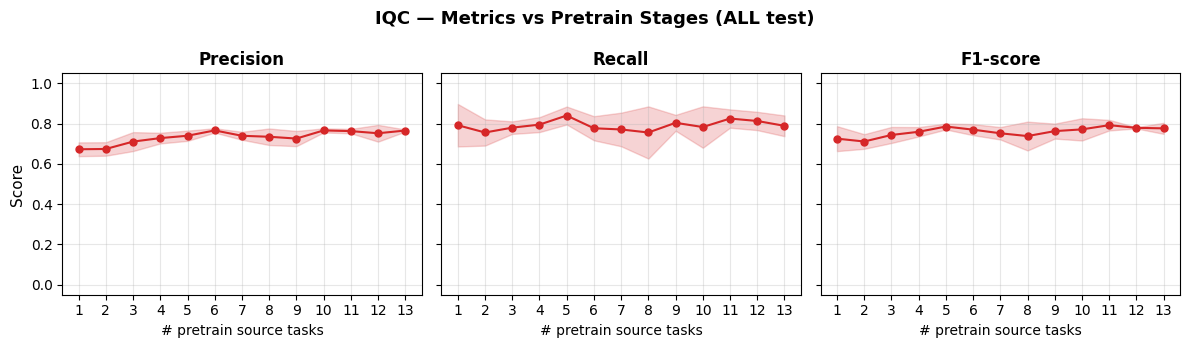

  Saved: ../artifacts/multi_task_suite_260206_260211/per_class_others_ALL_test.png


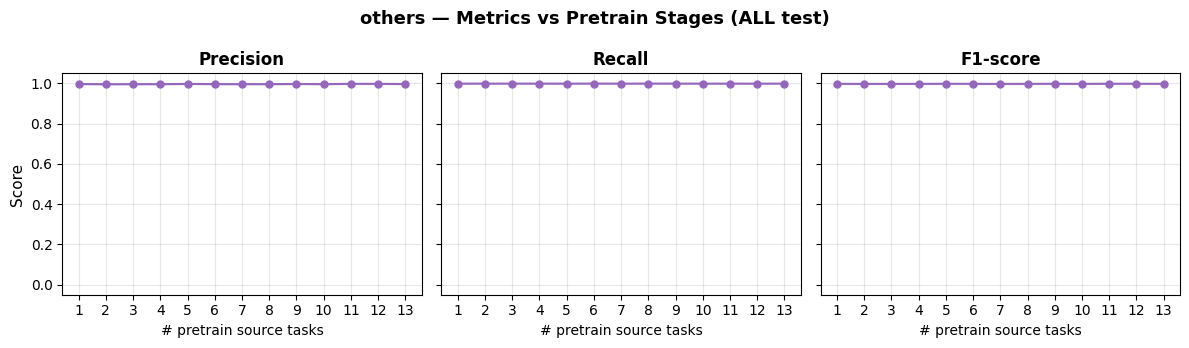

In [8]:
print(f"Loading reports from: {OUTPUT_DIR}\n")

# 1) ALL test
reports_all = load_clf_reports_from_disk(OUTPUT_DIR, "clf_report_all.json")
print(f"Found {len(reports_all)} run(s) with clf_report_all")
arr_all = plot_per_class_metrics(
    reports_all, CLASS_NAMES, n_stages,
    title_suffix=" (ALL test)",
    save_dir=OUTPUT_DIR,
)

Found 4 run(s) with clf_report_ge4
  Saved: ../artifacts/multi_task_suite_260206_260211/per_class_DAC_n_elements_>=_4.png


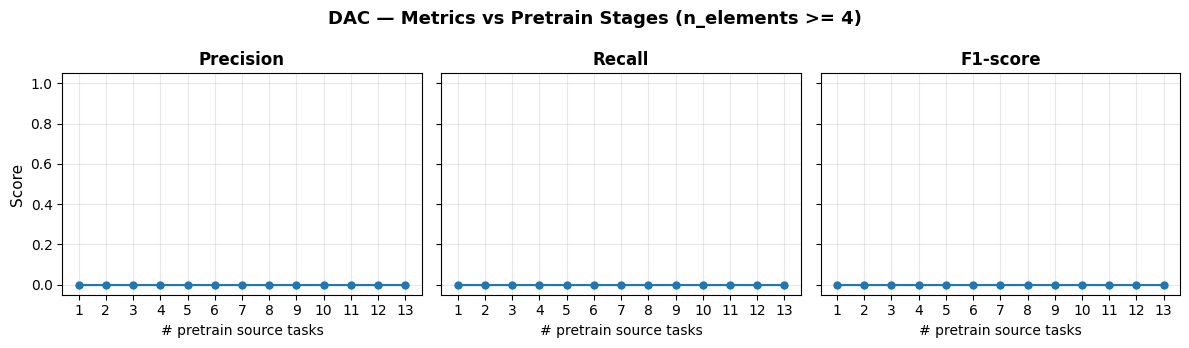

  Saved: ../artifacts/multi_task_suite_260206_260211/per_class_DQC_n_elements_>=_4.png


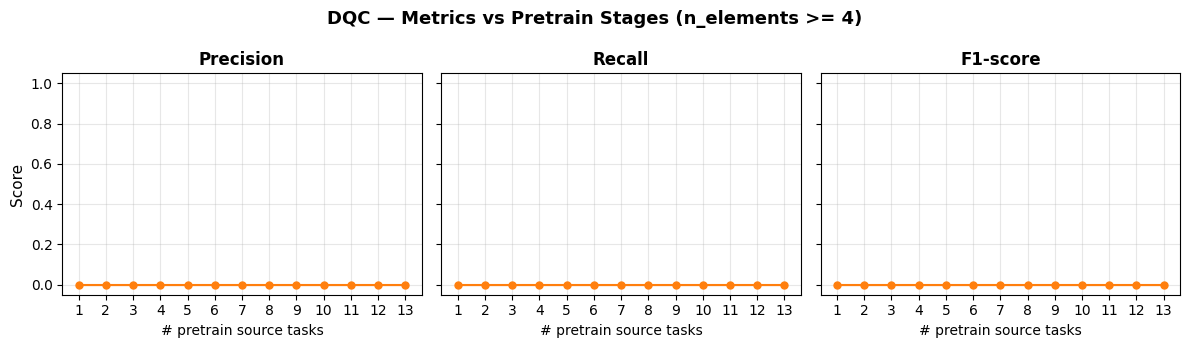

  Saved: ../artifacts/multi_task_suite_260206_260211/per_class_IAC_n_elements_>=_4.png


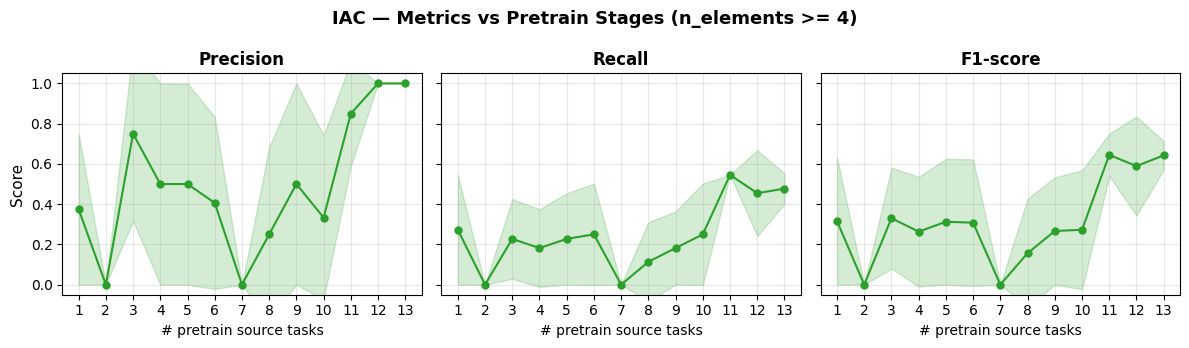

  Saved: ../artifacts/multi_task_suite_260206_260211/per_class_IQC_n_elements_>=_4.png


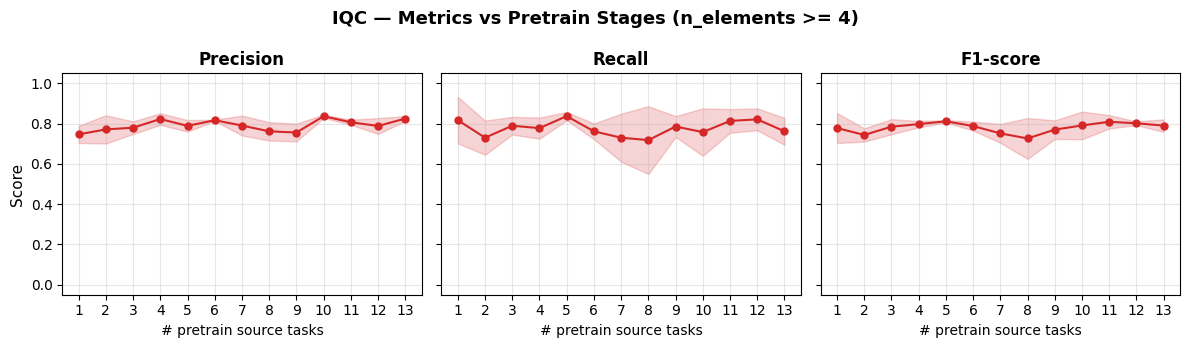

  Saved: ../artifacts/multi_task_suite_260206_260211/per_class_others_n_elements_>=_4.png


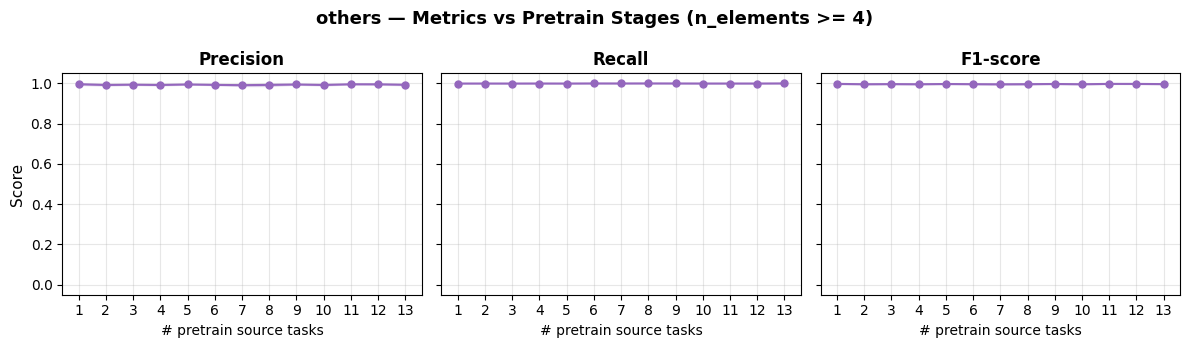

In [9]:
# 2) n_elements >= 4
reports_ge4 = load_clf_reports_from_disk(OUTPUT_DIR, "clf_report_ge4.json")
print(f"Found {len(reports_ge4)} run(s) with clf_report_ge4")
arr_ge4 = plot_per_class_metrics(
    reports_ge4, CLASS_NAMES, n_stages,
    title_suffix=" (n_elements >= 4)",
    save_dir=OUTPUT_DIR,
)

## 7. 数值总结

In [10]:
import pandas as pd

metrics_of_interest = ["precision", "recall", "f1-score"]

# --- ALL test ---
print("=== Per-class Metrics Summary (ALL test) ===")
rows_all = []
for c_idx, cname in enumerate(CLASS_NAMES):
    print(f"\n  {cname}:")
    for m_idx, metric in enumerate(metrics_of_interest):
        vals = arr_all[:, :, c_idx, m_idx]  # [n_runs, n_stages]
        mean_v = np.nanmean(vals, axis=0)
        std_v = np.nanstd(vals, axis=0)
        line = "    " + metric.ljust(12)
        for s in range(n_stages):
            line += f"  S{s+1}: {mean_v[s]:.3f}±{std_v[s]:.3f}"
            rows_all.append({"class": cname, "metric": metric, "stage": s + 1,
                             "mean": round(mean_v[s], 4), "std": round(std_v[s], 4)})
        print(line)

df_metrics_all = pd.DataFrame(rows_all)
csv_path_all = OUTPUT_DIR / "per_class_metrics_summary_all_test.csv"
df_metrics_all.to_csv(csv_path_all, index=False)
print(f"\nSaved to {csv_path_all}")

# --- n_elements >= 4 ---
print("\n\n=== Per-class Metrics Summary (n_elements ≥ 4) ===")
rows_ge4 = []
for c_idx, cname in enumerate(CLASS_NAMES):
    print(f"\n  {cname}:")
    for m_idx, metric in enumerate(metrics_of_interest):
        vals = arr_ge4[:, :, c_idx, m_idx]
        mean_v = np.nanmean(vals, axis=0)
        std_v = np.nanstd(vals, axis=0)
        line = "    " + metric.ljust(12)
        for s in range(n_stages):
            line += f"  S{s+1}: {mean_v[s]:.3f}±{std_v[s]:.3f}"
            rows_ge4.append({"class": cname, "metric": metric, "stage": s + 1,
                             "mean": round(mean_v[s], 4), "std": round(std_v[s], 4)})
        print(line)

df_metrics_ge4 = pd.DataFrame(rows_ge4)
csv_path_ge4 = OUTPUT_DIR / "per_class_metrics_summary_ge4_test.csv"
df_metrics_ge4.to_csv(csv_path_ge4, index=False)
print(f"\nSaved to {csv_path_ge4}")

=== Per-class Metrics Summary (ALL test) ===

  DAC:
    precision     S1: 0.125±0.217  S2: 0.125±0.217  S3: 0.083±0.144  S4: 0.000±0.000  S5: 0.125±0.217  S6: 0.375±0.415  S7: 0.250±0.250  S8: 0.050±0.087  S9: 0.188±0.207  S10: 0.375±0.415  S11: 0.708±0.298  S12: 0.333±0.408  S13: 0.375±0.415
    recall        S1: 0.125±0.217  S2: 0.125±0.217  S3: 0.125±0.217  S4: 0.000±0.000  S5: 0.125±0.217  S6: 0.250±0.250  S7: 0.250±0.250  S8: 0.125±0.217  S9: 0.250±0.250  S10: 0.250±0.250  S11: 0.500±0.000  S12: 0.250±0.250  S13: 0.250±0.250
    f1-score      S1: 0.125±0.217  S2: 0.125±0.217  S3: 0.100±0.173  S4: 0.000±0.000  S5: 0.125±0.217  S6: 0.292±0.298  S7: 0.250±0.250  S8: 0.071±0.124  S9: 0.208±0.217  S10: 0.292±0.298  S11: 0.558±0.114  S12: 0.267±0.283  S13: 0.292±0.298

  DQC:
    precision     S1: 0.000±0.000  S2: 0.000±0.000  S3: 0.000±0.000  S4: 0.000±0.000  S5: 0.000±0.000  S6: 0.000±0.000  S7: 0.000±0.000  S8: 0.000±0.000  S9: 0.000±0.000  S10: 0.000±0.000  S11: 0.000±0.000  S12: 0

## 8. Dataset Composition Analysis

加载原始数据，分析各 class 在 train / test 中的样本数量，以及 n_elements ≥ 4 的样本数量，
帮助整体了解数据集构成及类别不平衡情况。

In [11]:
import joblib
import pandas as pd

# === 加载原始数据 ===
DATA_PATH = OUTPUT_DIR.parent / "data" if (OUTPUT_DIR.parent / "data").exists() else Path("../data")
# Fallback: use hardcoded paths relative to notebooks/
data_parquet = Path("../data/qc_ac_te_mp_dos_reformat_20250615_enforce_quaternary_test.pd.parquet")
desc_parquet = Path("../data/qc_ac_te_mp_dos_composition_desc_trans_20250615.pd.parquet")
preprocessing_pkl = Path("../data/preprocessing_objects_20250615.pkl.z")

preprocessing_objects = joblib.load(preprocessing_pkl)
all_data = pd.read_parquet(data_parquet)
dropped_idx = preprocessing_objects.get("dropped_idx", [])
all_data = all_data.loc[~all_data.index.isin(dropped_idx)]

# Label encoder
le = preprocessing_objects.get("material_type_label_encoder")
if le is not None:
    class_names_data = list(le.classes_)
else:
    class_names_data = CLASS_NAMES

# n_elements
all_data["n_elements"] = all_data["elements"].apply(len)

# Classification subset (non-NaN labels)
clf_data = all_data.dropna(subset=["Material type (label)"]).copy()
clf_data["Material type (label)"] = clf_data["Material type (label)"].astype(int)

# Map integer labels back to class names
label_to_name = {i: name for i, name in enumerate(class_names_data)}
clf_data["class_name"] = clf_data["Material type (label)"].map(label_to_name)

print(f"Total data rows (after drop): {len(all_data)}")
print(f"Classification subset rows:   {len(clf_data)}")
print(f"Classes: {class_names_data}")

/Users/liuchang/projects/foundation_model/.venv/lib/python3.12/site-packages/sklearn/base.py:442: InconsistentVersionWarning: Trying to unpickle estimator StandardScaler from version 1.7.0 when using version 1.7.2. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit-learn.org/stable/model_persistence.html#security-maintainability-limitations
  warnings.warn(
/Users/liuchang/projects/foundation_model/.venv/lib/python3.12/site-packages/sklearn/base.py:442: InconsistentVersionWarning: Trying to unpickle estimator PowerTransformer from version 1.7.0 when using version 1.7.2. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit-learn.org/stable/model_persistence.html#security-maintainability-limitations
  warnings.warn(
/Users/liuchang/projects/foundation_model/.venv/lib/python3.12/site-packages/sklearn/base.py:442: InconsistentVersionWarning: Trying to un

Total data rows (after drop): 48998
Classification subset rows:   48998
Classes: ['DAC', 'DQC', 'IAC', 'IQC', 'others']


In [12]:
# === 按 split 统计各 class 的数量 ===
if "split" in clf_data.columns:
    split_col = "split"
else:
    # 如果没有 split 列，用 CompoundDataModule 的默认逻辑标注
    split_col = None
    print("Warning: no 'split' column found. Will show overall stats only.")

# --- 全量统计 ---
overall_counts = clf_data["class_name"].value_counts().sort_index()
overall_ge4 = clf_data[clf_data["n_elements"] >= 4]["class_name"].value_counts().sort_index()

print("=== Overall Class Distribution ===")
summary_rows = []
for cname in class_names_data:
    total = overall_counts.get(cname, 0)
    ge4 = overall_ge4.get(cname, 0)
    summary_rows.append({
        "Class": cname,
        "Total": total,
        "n_elements >= 4": ge4,
        "% of total": f"{100 * total / len(clf_data):.1f}%",
        "% ge4 in class": f"{100 * ge4 / total:.1f}%" if total > 0 else "N/A",
    })

summary_df = pd.DataFrame(summary_rows)
# Add totals row
summary_df.loc[len(summary_df)] = [
    "TOTAL",
    summary_df["Total"].sum(),
    summary_df["n_elements >= 4"].sum(),
    "100.0%",
    f"{100 * summary_df['n_elements >= 4'].sum() / summary_df['Total'].sum():.1f}%",
]
print(summary_df.to_string(index=False))

# Save overall summary CSV
csv_overall = OUTPUT_DIR / "dataset_overall_class_distribution.csv"
summary_df.to_csv(csv_overall, index=False)
print(f"\nSaved to {csv_overall}")

# --- 按 split 统计 ---
all_split_dfs = []
if split_col:
    print("\n=== Per-Split Class Distribution ===")
    for split_name in ["train", "val", "test"]:
        subset = clf_data[clf_data[split_col] == split_name]
        if len(subset) == 0:
            continue
        print(f"\n  [{split_name.upper()}] ({len(subset)} samples)")
        split_counts = subset["class_name"].value_counts().sort_index()
        split_ge4 = subset[subset["n_elements"] >= 4]["class_name"].value_counts().sort_index()
        rows = []
        for cname in class_names_data:
            cnt = split_counts.get(cname, 0)
            g4 = split_ge4.get(cname, 0)
            rows.append({
                "Split": split_name,
                "Class": cname,
                "Count": cnt,
                "n_elem>=4": g4,
                "% in split": f"{100 * cnt / len(subset):.1f}%",
            })
        split_df = pd.DataFrame(rows)
        # Print with totals
        print_df = split_df.copy()
        print_df.loc[len(print_df)] = [
            split_name, "TOTAL", print_df["Count"].sum(), print_df["n_elem>=4"].sum(), "100.0%"
        ]
        print(print_df.to_string(index=False))
        all_split_dfs.append(split_df)

    # Save per-split CSV
    if all_split_dfs:
        df_splits = pd.concat(all_split_dfs, ignore_index=True)
        csv_splits = OUTPUT_DIR / "dataset_per_split_class_distribution.csv"
        df_splits.to_csv(csv_splits, index=False)
        print(f"\nSaved to {csv_splits}")

=== Overall Class Distribution ===
 Class  Total  n_elements >= 4 % of total % ge4 in class
   DAC     13                1       0.0%           7.7%
   DQC     15                7       0.0%          46.7%
   IAC    126               11       0.3%           8.7%
   IQC    213               63       0.4%          29.6%
others  48631            18465      99.3%          38.0%
 TOTAL  48998            18547     100.0%          37.9%

Saved to ../artifacts/multi_task_suite_260206_260211/dataset_overall_class_distribution.csv

=== Per-Split Class Distribution ===

  [TRAIN] (34295 samples)
Split  Class  Count  n_elem>=4 % in split
train    DAC     10          0       0.0%
train    DQC      5          0       0.0%
train    IAC     76          0       0.2%
train    IQC    106          0       0.3%
train others  34098      12969      99.4%
train  TOTAL  34295      12969     100.0%

  [VAL] (7349 samples)
Split  Class  Count  n_elem>=4 % in split
  val    DAC      1          0       0.0%
  val 

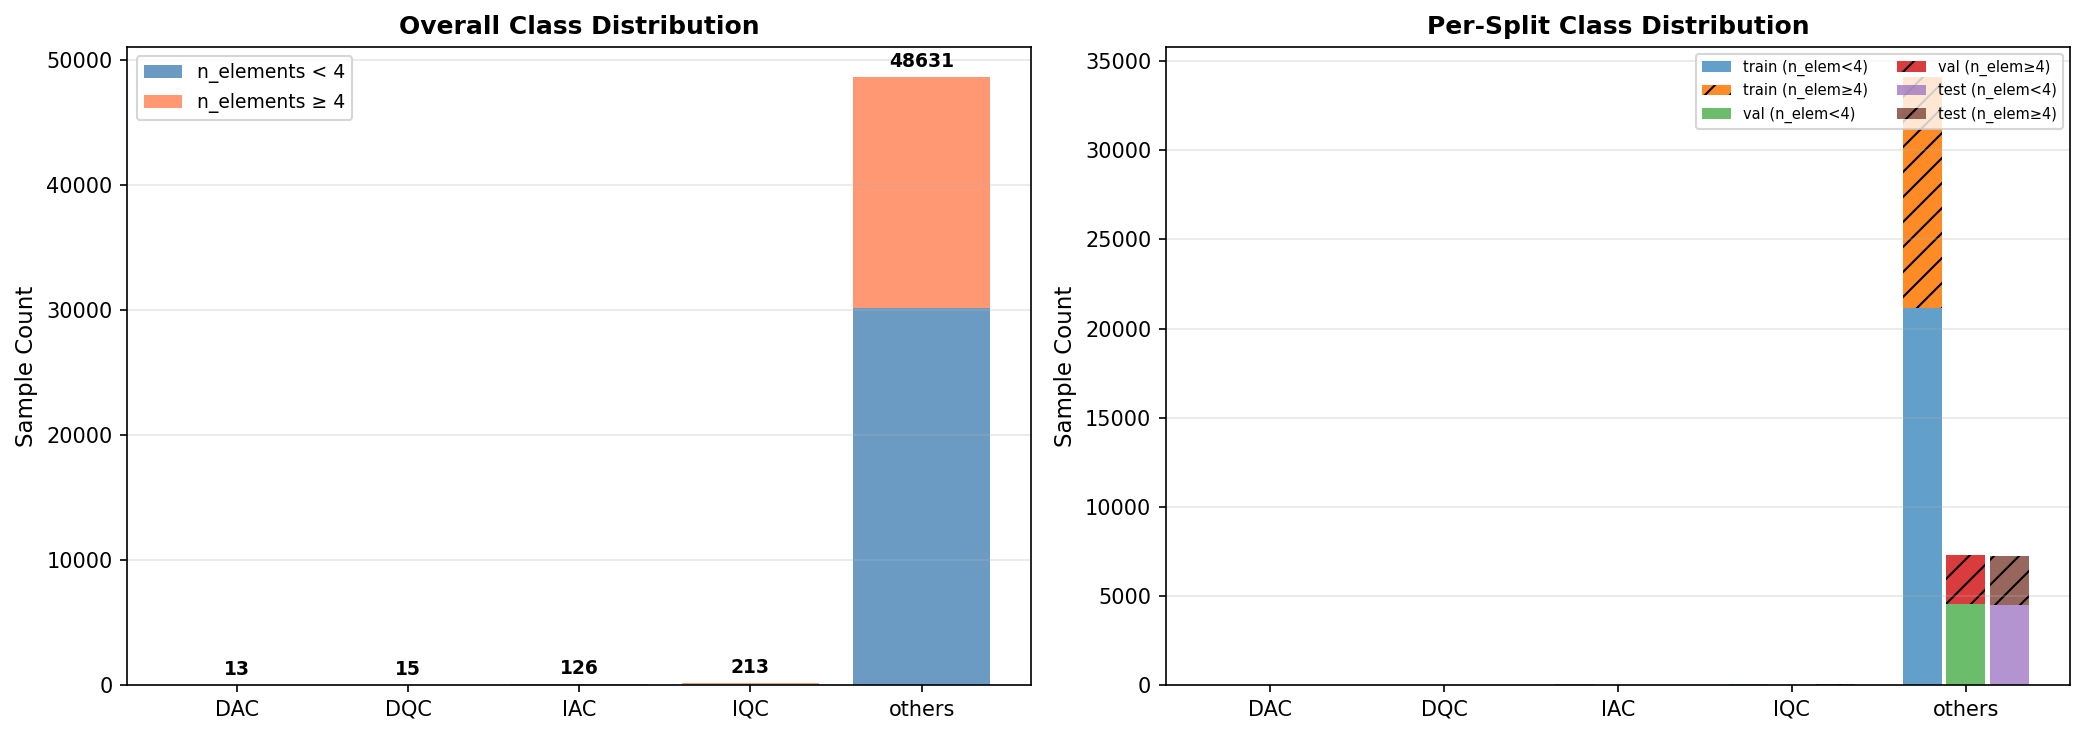

Saved to ../artifacts/multi_task_suite_260206_260211/dataset_composition.png


In [13]:
# === 可视化: 各 class 样本数量 bar chart ===
fig, axes = plt.subplots(1, 2, figsize=(14, 5), dpi=150)

# --- (a) Overall class distribution ---
ax = axes[0]
x = np.arange(len(class_names_data))
total_counts = [overall_counts.get(c, 0) for c in class_names_data]
ge4_counts = [overall_ge4.get(c, 0) for c in class_names_data]
lt4_counts = [t - g for t, g in zip(total_counts, ge4_counts)]

bars_lt4 = ax.bar(x, lt4_counts, label="n_elements < 4", color="steelblue", alpha=0.8)
bars_ge4 = ax.bar(x, ge4_counts, bottom=lt4_counts, label="n_elements ≥ 4", color="coral", alpha=0.8)

ax.set_xticks(x)
ax.set_xticklabels(class_names_data, fontsize=10)
ax.set_ylabel("Sample Count", fontsize=11)
ax.set_title("Overall Class Distribution", fontsize=12, fontweight="bold")
ax.legend(fontsize=9)
ax.grid(True, alpha=0.3, axis="y")

# Add count labels
for i, (t, g) in enumerate(zip(total_counts, ge4_counts)):
    ax.text(i, t + max(total_counts) * 0.01, str(t), ha="center", va="bottom", fontsize=9, fontweight="bold")

# --- (b) Per-split distribution ---
if split_col:
    ax = axes[1]
    splits = ["train", "val", "test"]
    n_splits = len(splits)
    width = 0.25
    offsets = np.arange(n_splits) * width - width

    for c_idx, cname in enumerate(class_names_data):
        counts_per_split = []
        ge4_per_split = []
        for sname in splits:
            subset = clf_data[clf_data[split_col] == sname]
            cnt = (subset["class_name"] == cname).sum()
            g4 = ((subset["class_name"] == cname) & (subset["n_elements"] >= 4)).sum()
            counts_per_split.append(cnt)
            ge4_per_split.append(g4)

        x_pos = np.arange(n_splits) + c_idx * width / len(class_names_data) * n_splits
        # Simplified: grouped bar by split
        pass  # Will use a different layout below

    # Simpler: stacked bar per split, with classes as groups
    split_data_all = {}
    split_data_ge4 = {}
    for sname in splits:
        subset = clf_data[clf_data[split_col] == sname]
        split_data_all[sname] = {c: (subset["class_name"] == c).sum() for c in class_names_data}
        split_data_ge4[sname] = {
            c: ((subset["class_name"] == c) & (subset["n_elements"] >= 4)).sum()
            for c in class_names_data
        }

    x = np.arange(len(class_names_data))
    width = 0.25
    for s_idx, sname in enumerate(splits):
        all_vals = [split_data_all[sname][c] for c in class_names_data]
        ge4_vals = [split_data_ge4[sname][c] for c in class_names_data]
        lt4_vals = [a - g for a, g in zip(all_vals, ge4_vals)]

        offset = (s_idx - 1) * width
        bars = ax.bar(x + offset, lt4_vals, width * 0.9, label=f"{sname} (n_elem<4)", alpha=0.7)
        ax.bar(x + offset, ge4_vals, width * 0.9, bottom=lt4_vals,
               label=f"{sname} (n_elem≥4)", alpha=0.9, hatch="//")

    ax.set_xticks(x)
    ax.set_xticklabels(class_names_data, fontsize=10)
    ax.set_ylabel("Sample Count", fontsize=11)
    ax.set_title("Per-Split Class Distribution", fontsize=12, fontweight="bold")
    ax.legend(fontsize=7, loc="upper right", ncol=2)
    ax.grid(True, alpha=0.3, axis="y")
else:
    axes[1].text(0.5, 0.5, "No split column available", ha="center", va="center", fontsize=12)
    axes[1].set_axis_off()

fig.tight_layout()
fig.savefig(OUTPUT_DIR / "dataset_composition.png", dpi=150, bbox_inches="tight")
plt.show()
print(f"Saved to {OUTPUT_DIR / 'dataset_composition.png'}")

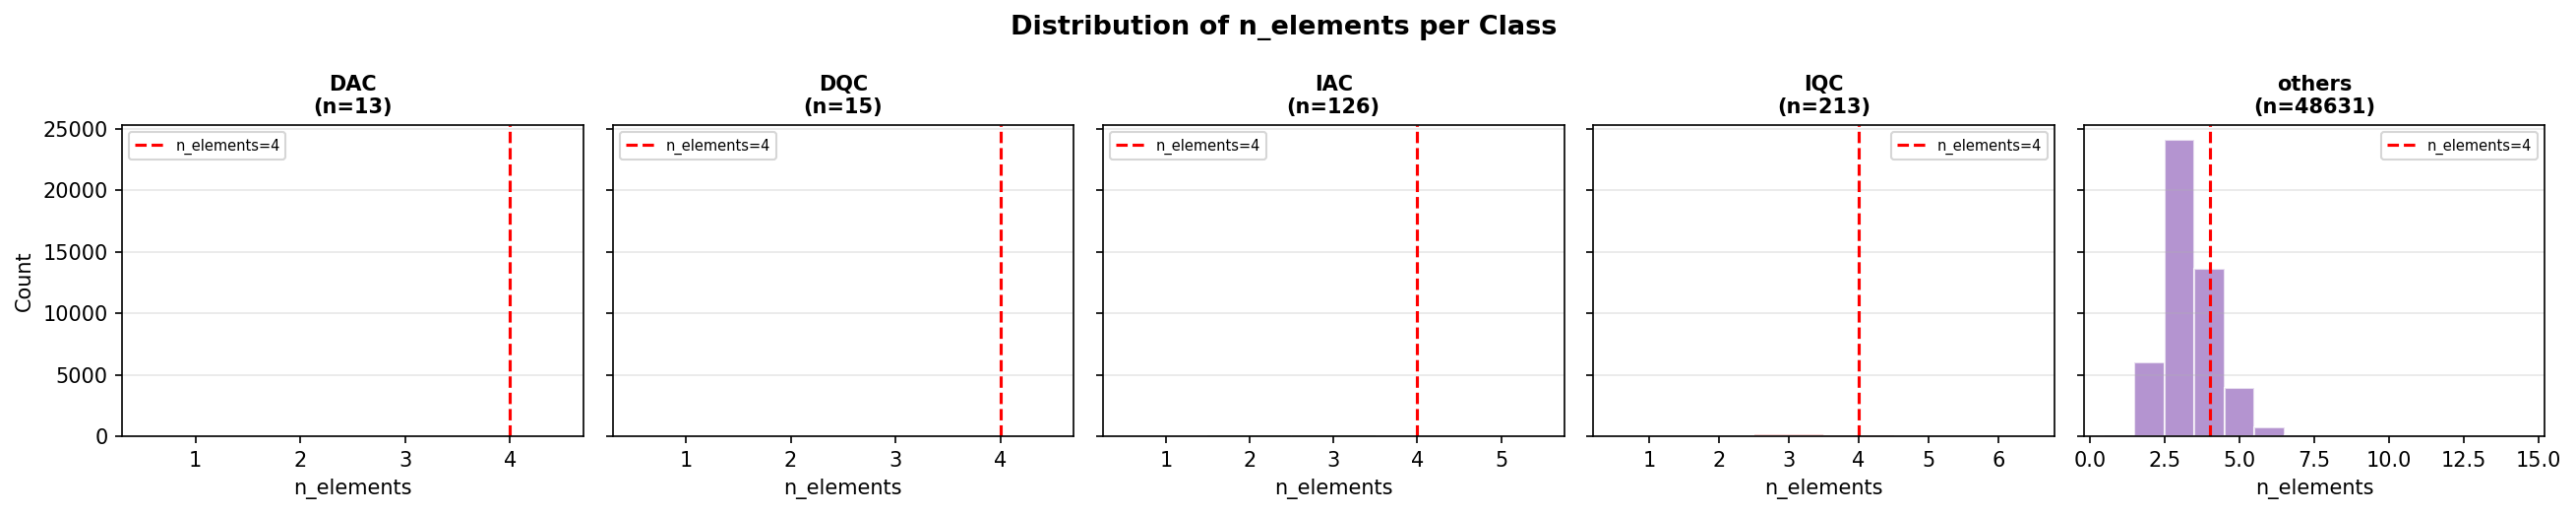

Saved to ../artifacts/multi_task_suite_260206_260211/n_elements_per_class.png


In [14]:
# === n_elements 分布直方图 (按 class 分面) ===
fig, axes = plt.subplots(1, len(class_names_data), figsize=(3.5 * len(class_names_data), 3.5), dpi=150, sharey=True)
colors = plt.cm.tab10.colors

for c_idx, cname in enumerate(class_names_data):
    ax = axes[c_idx]
    subset = clf_data[clf_data["class_name"] == cname]
    n_elem = subset["n_elements"]

    ax.hist(n_elem, bins=range(1, n_elem.max() + 2), color=colors[c_idx], alpha=0.7, edgecolor="white", align="left")
    ax.axvline(x=4, color="red", linestyle="--", linewidth=1.5, label="n_elements=4")
    ax.set_title(f"{cname}\n(n={len(subset)})", fontsize=10, fontweight="bold")
    ax.set_xlabel("n_elements")
    if c_idx == 0:
        ax.set_ylabel("Count")
    ax.legend(fontsize=7)
    ax.grid(True, alpha=0.3, axis="y")

fig.suptitle("Distribution of n_elements per Class", fontsize=13, fontweight="bold")
fig.tight_layout()
fig.savefig(OUTPUT_DIR / "n_elements_per_class.png", dpi=150, bbox_inches="tight")
plt.show()
print(f"Saved to {OUTPUT_DIR / 'n_elements_per_class.png'}")

## 9. Confusion Matrix (Final Stage)

从每个 run 的最终 stage checkpoint 加载模型，执行 inference 生成 confusion matrix。
**NOTE**: 仅执行推理，不重新训练。每个 checkpoint 只需几秒。

In [18]:
import copy

import seaborn as sns
import torch
from lightning.pytorch import Trainer
from sklearn.metrics import confusion_matrix

from foundation_model.data.datamodule import CompoundDataModule
from foundation_model.models.flexible_multi_task_model import FlexibleMultiTaskModel
from foundation_model.models.model_config import (
    ClassificationTaskConfig,
    EncoderType,
    KernelRegressionTaskConfig,
    MLPEncoderConfig,
    OptimizerConfig,
    RegressionTaskConfig,
    TaskType,
    TransformerEncoderConfig,
)


torch.serialization.add_safe_globals(
    [
        RegressionTaskConfig,
        ClassificationTaskConfig,
        KernelRegressionTaskConfig,
        OptimizerConfig,
        TransformerEncoderConfig,
        MLPEncoderConfig,
        TaskType,
        EncoderType,
    ]
)

# --- Config (must match training) ---
LATENT_DIM = 128
HEAD_HIDDEN_DIM = 64
HEAD_LR = 0.005
ENCODER_LR = 5e-2
BATCH_SIZE = 128
DATAMODULE_RANDOM_SEED = 42

data_parquet = Path("../data/qc_ac_te_mp_dos_reformat_20250615_enforce_quaternary_test.pd.parquet")
desc_parquet = Path("../data/qc_ac_te_mp_dos_composition_desc_trans_20250615.pd.parquet")
preprocessing_pkl = Path("../data/preprocessing_objects_20250615.pkl.z")

desc_trans = pd.read_parquet(desc_parquet)
x_dim = desc_trans.shape[1]
num_classes = len(CLASS_NAMES)

encoder_config = MLPEncoderConfig(hidden_dims=[x_dim, 256, LATENT_DIM], norm=True, residual=False)
clf_task_config = ClassificationTaskConfig(
    name="material_type",
    data_column="Material type (label)",
    dims=[LATENT_DIM, HEAD_HIDDEN_DIM, 32],
    num_classes=num_classes,
    norm=True, residual=False,
    optimizer=OptimizerConfig(lr=HEAD_LR, weight_decay=1e-5),
)

# n_elements series for ge4 filtering
n_elements_series = all_data["elements"].apply(len)


def build_finetune_dm():
    data_col = "Material type (label)"
    columns = [data_col]
    if "split" in all_data.columns:
        columns.append("split")
    attributes = all_data[columns].dropna(subset=[data_col]).copy()
    return CompoundDataModule(
        formula_desc_source=desc_trans,
        attributes_source=attributes,
        task_configs=[copy.deepcopy(clf_task_config)],
        random_seed=DATAMODULE_RANDOM_SEED,
        batch_size=BATCH_SIZE,
        num_workers=0,
    )


def collect_predictions(batch_preds):
    labels = []
    for batch in batch_preds:
        if "material_type_label" in batch:
            labels.append(batch["material_type_label"])
    return np.concatenate(labels) if labels else np.array([])


def collect_true(dataset):
    y_list = []
    for i in range(len(dataset)):
        y = dataset[i][1]["material_type"]
        y_list.append(y.numpy())
    return np.concatenate(y_list)


print(f"Config ready. x_dim={x_dim}, num_classes={num_classes}")
print(f"Will generate confusion matrices from checkpoints in: {OUTPUT_DIR}")

Config ready. x_dim=290, num_classes=5
Will generate confusion matrices from checkpoints in: ../artifacts/multi_task_suite_260206_260211


In [19]:
# --- Generate confusion matrices from final-stage finetune checkpoints (inference only) ---
from sklearn.metrics import confusion_matrix as sk_confusion_matrix

cm_results = {}  # {run_label: {"all": np.ndarray, "ge4": np.ndarray}}

# Build datamodule once and set up
dm = build_finetune_dm()
dm.setup(stage="fit")
dm.setup(stage="test")

# n_elements >= 4 mask aligned to test set
test_n_elem = n_elements_series.loc[dm.test_idx].values
ge4_mask_test = test_n_elem >= 4

# True labels (compute once)
test_true = collect_true(dm.test_dataset)
test_valid = test_true.flatten() != -100
test_ge4_valid = test_valid & ge4_mask_test

print(f"Test samples: {int(test_valid.sum())} total, {int(test_ge4_valid.sum())} n_elements>=4")
print(f"Generating confusion matrices from final-stage checkpoints...\n")

for run_label in run_labels:
    run_dir = OUTPUT_DIR / run_label
    stage_dirs = sorted(run_dir.glob("pretrain_stage*"))
    if not stage_dirs:
        print(f"  {run_label}: no stage dirs found, skipping")
        continue
    final_stage_dir = stage_dirs[-1]
    ft_dir = final_stage_dir / "finetune" / "material_type"

    # Check if .npy already exists
    npy_all = ft_dir / "confusion_matrix_all.npy"
    npy_ge4 = ft_dir / "confusion_matrix_ge4.npy"
    if npy_all.exists() and npy_ge4.exists():
        cm_results[run_label] = {
            "all": np.load(npy_all),
            "ge4": np.load(npy_ge4),
        }
        print(f"  {run_label} ({final_stage_dir.name}): loaded existing .npy")
        continue

    # Find checkpoint
    ckpt_files = sorted(ft_dir.glob("checkpoints/*.ckpt"))
    if not ckpt_files:
        print(f"  {run_label}: no checkpoint in {ft_dir}, skipping")
        continue
    ckpt_path = str(ckpt_files[0])

    # Build model with clf head and load checkpoint state
    model = FlexibleMultiTaskModel(
        task_configs=[copy.deepcopy(clf_task_config)],
        encoder_config=copy.deepcopy(encoder_config),
        enable_learnable_loss_balancer=True,
        freeze_shared_encoder=True,
        shared_block_optimizer=OptimizerConfig(lr=ENCODER_LR),
    )
    state = torch.load(ckpt_path, map_location="cpu", weights_only=True)
    model.load_state_dict(state["state_dict"], strict=False)
    model.eval()

    # Inference
    trainer = Trainer(accelerator="auto", devices=1, logger=False, enable_progress_bar=False)
    preds = trainer.predict(model, dataloaders=dm.test_dataloader())
    pred_labels = collect_predictions(preds)

    # Compute confusion matrices
    cm_all = sk_confusion_matrix(
        test_true.flatten()[test_valid],
        pred_labels.flatten()[test_valid],
        labels=list(range(num_classes)),
    )
    cm_ge4 = sk_confusion_matrix(
        test_true.flatten()[test_ge4_valid],
        pred_labels.flatten()[test_ge4_valid],
        labels=list(range(num_classes)),
    )

    # Save
    np.save(npy_all, cm_all)
    np.save(npy_ge4, cm_ge4)
    cm_results[run_label] = {"all": cm_all, "ge4": cm_ge4}
    print(f"  {run_label} ({final_stage_dir.name}): computed & saved  all={cm_all.shape} ge4={cm_ge4.shape}")

print(f"\nDone. Confusion matrices for {len(cm_results)} runs.")

2026-02-13 03:26:36.403 | INFO     | datamodule:__init__:299 - Initializing CompoundDataModule...
2026-02-13 03:26:36.403 | INFO     | datamodule:__init__:336 - --- Loading Data ---
2026-02-13 03:26:36.403 | INFO     | datamodule:_load_data:623 - Using provided pd.DataFrame for 'formula_desc' data.
2026-02-13 03:26:36.409 | INFO     | datamodule:_load_data:630 - Successfully loaded 'formula_desc'. Shape: (48998, 290)
2026-02-13 03:26:36.409 | INFO     | datamodule:__init__:341 - Initial loaded formula_df length: 48998
2026-02-13 03:26:36.419 | INFO     | datamodule:__init__:348 - Formula_df length after initial dropna: 48998. This index is now the master reference.
2026-02-13 03:26:36.419 | INFO     | datamodule:_load_data:623 - Using provided pd.DataFrame for 'attributes' data.
2026-02-13 03:26:36.420 | INFO     | datamodule:_load_data:630 - Successfully loaded 'attributes'. Shape: (48998, 2)
2026-02-13 03:26:36.420 | INFO     | datamodule:__init__:362 - Initial loaded attributes_df l

Test samples: 7354 total, 2817 n_elements>=4
Generating confusion matrices from final-stage checkpoints...



2026-02-13 03:26:37.229 | INFO     | flexible_multi_task_model:__init__:158 - Learnable task uncertainty (task_log_sigmas) is ENABLED.
2026-02-13 03:26:37.231 | INFO     | flexible_multi_task_model:__init__:181 - Initializing FlexibleMultiTaskModel...
2026-02-13 03:26:37.231 | INFO     | flexible_multi_task_model:__init__:182 - Registered Task Heads:
2026-02-13 03:26:37.232 | INFO     | flexible_multi_task_model:__init__:189 -            name           type  enabled
2026-02-13 03:26:37.232 | INFO     | flexible_multi_task_model:__init__:189 -   material_type CLASSIFICATION     True
2026-02-13 03:26:37.232 | INFO     | flexible_multi_task_model:__init__:193 - FlexibleMultiTaskModel Structure:
2026-02-13 03:26:37.232 | INFO     | flexible_multi_task_model:__init__:197 -   FlexibleMultiTaskModel(
2026-02-13 03:26:37.233 | INFO     | flexible_multi_task_model:__init__:197 -     (task_log_sigmas): ParameterDict(  (material_type): Parameter containing: [torch.FloatTensor of size ])
2026-02-1

  run01 (pretrain_stage13_density): computed & saved  all=(5, 5) ge4=(5, 5)
  run02 (pretrain_stage13_seebeck_coefficient): computed & saved  all=(5, 5) ge4=(5, 5)


/Users/liuchang/projects/foundation_model/.venv/lib/python3.12/site-packages/lightning/pytorch/trainer/connectors/data_connector.py:433: The 'predict_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=15` in the `DataLoader` to improve performance.
/Users/liuchang/projects/foundation_model/.venv/lib/python3.12/site-packages/torch/utils/data/dataloader.py:684: UserWarning: 'pin_memory' argument is set as true but not supported on MPS now, then device pinned memory won't be used.
  warnings.warn(warn_msg)
2026-02-13 03:26:37.473 | INFO     | flexible_multi_task_model:__init__:158 - Learnable task uncertainty (task_log_sigmas) is ENABLED.
2026-02-13 03:26:37.475 | INFO     | flexible_multi_task_model:__init__:181 - Initializing FlexibleMultiTaskModel...
2026-02-13 03:26:37.475 | INFO     | flexible_multi_task_model:__init__:182 - Registered Task Heads:
2026-02-13 03:26:37.476 | INFO     | flexible_

  run03 (pretrain_stage13_density): computed & saved  all=(5, 5) ge4=(5, 5)
  run04 (pretrain_stage13_electrical_resistivity): computed & saved  all=(5, 5) ge4=(5, 5)

Done. Confusion matrices for 4 runs.


  Saved: ../artifacts/multi_task_suite_260206_260211/confusion_matrix_final_stage_all.png


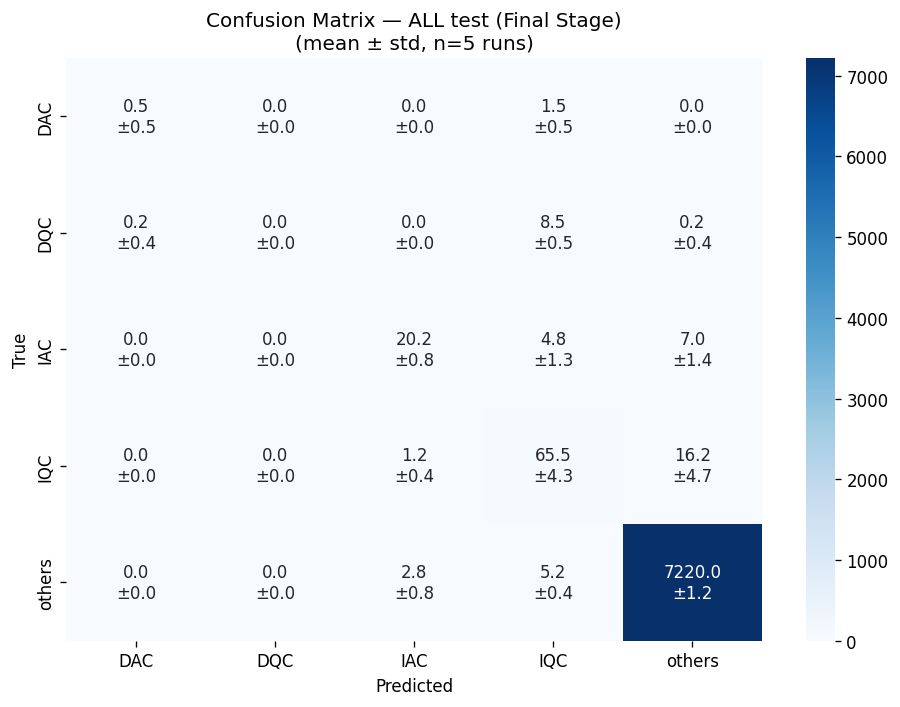

  Saved: ../artifacts/multi_task_suite_260206_260211/confusion_matrix_final_stage_ge4.png


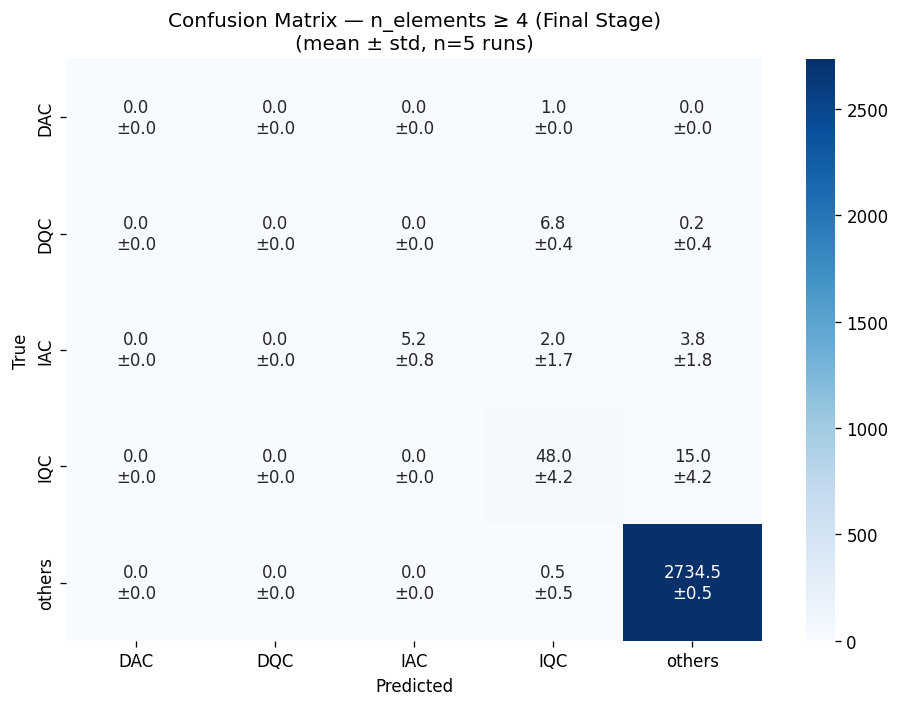

  Saved mean CM CSV (ALL test): ../artifacts/multi_task_suite_260206_260211/confusion_matrix_final_stage_all.csv
  Saved mean CM CSV (n_elements >= 4): ../artifacts/multi_task_suite_260206_260211/confusion_matrix_final_stage_ge4.csv


In [21]:
# --- Aggregated confusion matrix heatmaps (mean ± std across runs) ---

def plot_aggregated_cm(cm_dict, subset_key, title_suffix, class_names, save_path=None):
    """Plot mean±std confusion matrix heatmap from multiple runs."""
    matrices = [v[subset_key] for v in cm_dict.values() if subset_key in v]
    if not matrices:
        print(f"  No matrices for subset '{subset_key}'")
        return
    stack = np.stack(matrices).astype(float)
    mean_cm = stack.mean(axis=0)
    std_cm = stack.std(axis=0)

    # Build annotation strings: "mean\n±std"
    annot = np.empty(mean_cm.shape, dtype=object)
    for i in range(mean_cm.shape[0]):
        for j in range(mean_cm.shape[1]):
            annot[i, j] = f"{mean_cm[i, j]:.1f}\n±{std_cm[i, j]:.1f}"

    fig, ax = plt.subplots(figsize=(8, 6), dpi=120)
    sns.heatmap(
        mean_cm,
        annot=annot,
        fmt="",
        cmap="Blues",
        xticklabels=class_names,
        yticklabels=class_names,
        ax=ax,
    )
    ax.set_xlabel("Predicted")
    ax.set_ylabel("True")
    ax.set_title(f"Confusion Matrix — {title_suffix}\n(mean ± std, n={len(matrices) +1 } runs)")
    fig.tight_layout()
    if save_path:
        fig.savefig(save_path, bbox_inches="tight")
        print(f"  Saved: {save_path}")
    plt.show()


if cm_results:
    plot_aggregated_cm(
        cm_results, "all",
        "ALL test (Final Stage)",
        CLASS_NAMES,
        save_path=OUTPUT_DIR / "confusion_matrix_final_stage_all.png",
    )
    plot_aggregated_cm(
        cm_results, "ge4",
        "n_elements ≥ 4 (Final Stage)",
        CLASS_NAMES,
        save_path=OUTPUT_DIR / "confusion_matrix_final_stage_ge4.png",
    )

    # Also save aggregated values as CSV for reference
    for subset_key, label in [("all", "ALL test"), ("ge4", "n_elements >= 4")]:
        matrices = [v[subset_key] for v in cm_results.values() if subset_key in v]
        if matrices:
            stack = np.stack(matrices).astype(float)
            mean_cm = stack.mean(axis=0)
            std_cm = stack.std(axis=0)
            df_mean = pd.DataFrame(mean_cm, index=CLASS_NAMES, columns=CLASS_NAMES)
            df_std = pd.DataFrame(std_cm, index=CLASS_NAMES, columns=CLASS_NAMES)
            csv_path = OUTPUT_DIR / f"confusion_matrix_final_stage_{subset_key}.csv"
            df_mean.to_csv(csv_path, float_format="%.2f")
            print(f"  Saved mean CM CSV ({label}): {csv_path}")
else:
    print("No confusion matrix data available. Run the previous cell first.")